In [37]:
import pandas as pd
from datetime import datetime, timezone

ts = 1771262338996
print(datetime.fromtimestamp(ts / 1000, tz=timezone.utc))   # if ms
print(datetime.fromtimestamp(ts / 1_000_000, tz=timezone.utc))  # if us

df_raw = pd.read_parquet("datasets/telonex_raw/polymarket_book_snapshot_5_2026-02-12_89171498381181174020555224130586827134775807314573063982146628093680724415.parquet")
print(df_raw["timestamp_us"].iloc[0])
print(df_raw["local_timestamp_us"].iloc[0])
df_raw['n_ts']=df_raw['timestamp_us']//1000000

# pd.set_option('display.max_rows', 500)
# df_raw[['n_ts','ask_price_0','ask_price_1','ask_price_2','ask_price_3', 'ask_price_4', 'bid_price_0', 'bid_price_1','bid_price_2','bid_price_3','bid_price_4']].tail(100)
df = pd.read_parquet("data/telonex_book_snapshots/btc-updown-5m-1771348200.parquet")
up = df[df["token_label"] == "Up"]
pd.set_option('display.max_rows', 500)
len(up[['exchange_timestamp', 'ask_price_1','ask_price_2','ask_price_3', 'ask_price_4', 'ask_price_5', 'ask_size_5', 'mid_price','bid_price_1','bid_price_2','bid_price_3','bid_price_4','bid_price_5']])
# # Find a row with at least 3 bid levels populated
# multi_bid = up[up["bid_price_2"] > 0].iloc[0]
# print("bids:", [(multi_bid[f"bid_price_{i}"], multi_bid[f"bid_size_{i}"]) for i in range(1,6)])
# print("asks:", [(multi_bid[f"ask_price_{i}"], multi_bid[f"ask_size_{i}"]) for i in range(1,6)])

2026-02-16 17:18:58.996000+00:00
1970-01-21 12:01:02.338996+00:00
1770873540349000
1770873540377921


15379

In [38]:
df = pd.read_parquet("data/telonex_book_snapshots/btc-updown-5m-1771348200.parquet")
up = df[df["token_label"] == "Up"].sort_values("exchange_timestamp")

# Time between updates in milliseconds
up["dt"] = up["exchange_timestamp"].diff()
print(up["dt"].describe())
print(f"\nUpdates per second: {1000 / up['dt'].median():.1f}")

# How often does best bid/ask actually change?
up["bid_changed"] = up["bid_price_1"].diff().abs() > 0
up["ask_changed"] = up["ask_price_1"].diff().abs() > 0
up["book_moved"]  = up["bid_changed"] | up["ask_changed"]
print(f"\nFraction of updates where top-of-book moved: {up['book_moved'].mean():.3f}")
print(f"That's {up['book_moved'].sum()} meaningful updates out of {len(up)}")

count    15378.000000
mean        19.507543
std         68.042634
min          1.000000
25%          2.000000
50%          4.000000
75%         12.000000
max       2314.000000
Name: dt, dtype: float64

Updates per second: 250.0

Fraction of updates where top-of-book moved: 0.046
That's 714 meaningful updates out of 15379


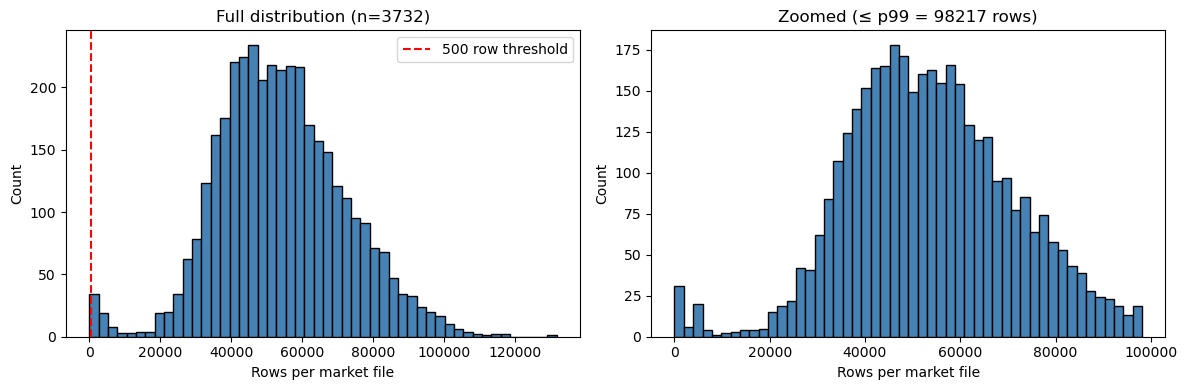

Total markets: 3732
Min: 2
p25: 41831
Median: 52911
p75: 65386
p99: 98217
Max: 131776
< 500 rows: 12


In [39]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sizes = []
for f in Path("data/telonex_book_snapshots").glob("btc-updown-5m-*.parquet"):
    df = pd.read_parquet(f, columns=["exchange_timestamp"])
    sizes.append(len(df))

sizes = np.array(sizes)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Full distribution
axes[0].hist(sizes, bins=50, edgecolor="black", color="steelblue")
axes[0].axvline(500, color="red", linestyle="--", label="500 row threshold")
axes[0].set_xlabel("Rows per market file")
axes[0].set_ylabel("Count")
axes[0].set_title(f"Full distribution (n={len(sizes)})")
axes[0].legend()

# Zoomed — drop top 1% to see the bulk
p99 = np.percentile(sizes, 99)
axes[1].hist(sizes[sizes <= p99], bins=50, edgecolor="black", color="steelblue")
axes[1].set_xlabel("Rows per market file")
axes[1].set_ylabel("Count")
axes[1].set_title(f"Zoomed (≤ p99 = {p99:.0f} rows)")

plt.tight_layout()
plt.savefig("rows_histogram.png", dpi=150)
plt.show()

print(f"Total markets: {len(sizes)}")
print(f"Min: {sizes.min()}")
print(f"p25: {np.percentile(sizes, 25):.0f}")
print(f"Median: {np.median(sizes):.0f}")
print(f"p75: {np.percentile(sizes, 75):.0f}")
print(f"p99: {np.percentile(sizes, 99):.0f}")
print(f"Max: {sizes.max()}")
print(f"< 500 rows: {(sizes < 500).sum()}")

In [40]:
import pandas as pd
import numpy as np

df = pd.read_parquet("data/telonex_book_snapshots/btc-updown-5m-1771340100.parquet")  # one of the busiest markets
up = df[df["token_label"] == "Up"].sort_values("exchange_timestamp")
up["dt"] = up["exchange_timestamp"].diff()

print("Update interval distribution (ms):")
print(up["dt"].describe())
print(f"\np50: {up['dt'].quantile(0.5):.1f}ms")
print(f"p90: {up['dt'].quantile(0.9):.1f}ms")
print(f"p99: {up['dt'].quantile(0.99):.1f}ms")

# How many rows would survive at different resample frequencies?
for freq_ms in [10, 50, 100, 250, 500, 1000]:
    n = int(300_000 / freq_ms)
    print(f"{freq_ms}ms → {n} steps/episode")

Update interval distribution (ms):
count    53686.000000
mean         5.587956
std         10.970242
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        281.000000
Name: dt, dtype: float64

p50: 2.0ms
p90: 13.0ms
p99: 52.0ms
10ms → 30000 steps/episode
50ms → 6000 steps/episode
100ms → 3000 steps/episode
250ms → 1200 steps/episode
500ms → 600 steps/episode
1000ms → 300 steps/episode


In [43]:
import numpy as np
from polymarket_env import PolymarketEnv

env = PolymarketEnv(deterministic=True)
obs, info = env.reset()

steps = 0
while True:
    masks = info["action_masks"]
    valid = np.where(masks)[0]
    action = np.random.choice(valid)
    obs, reward, term, trunc, info = env.step(action)
    steps += 1
    if term:
        print(f"Steps: {steps}")
        print(f"Reward: {reward:.4f}")
        print(f"Final bankroll: {info['bankroll']:.2f}")
        print(f"Realized PnL: {info['realized_pnl']:.4f}")
        break

Steps: 3000
Reward: 360.5062
Final bankroll: 10360.51
Realized PnL: 360.5062


In [42]:
pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.1/952.1 kB 14.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [gymnasium]
Note: you may need to restart the kernel to use updated packages.


In [44]:
env = PolymarketEnv(deterministic=True)
obs, info = env.reset()

np.random.seed(42)
trade_log = []
steps = 0
while True:
    masks = info["action_masks"]
    valid = np.where(masks)[0]
    action = np.random.choice(valid)
    obs, reward, term, trunc, info = env.step(action)
    steps += 1
    if action != 0:
        trade_log.append({
            "step": steps,
            "action": action,
            "yes_pos": info["yes_position"],
            "no_pos": info["no_position"],
            "bankroll": info["bankroll"],
            "realized_pnl": info["realized_pnl"],
        })
    if term:
        break

import pandas as pd
print(pd.DataFrame(trade_log).to_string())

      step  action  yes_pos  no_pos      bankroll  realized_pnl
0        1       3      0.0    50.0   9950.000000      0.000000
1        2       4      0.0   150.0   9850.000000      0.000000
2        3       2    100.0     0.0   9900.000000      0.000000
3        4       4      0.0   100.0   9900.000000      0.000000
4        5       4      0.0   200.0   9800.000000      0.000000
5        6       1     50.0     0.0   9950.000000      0.000000
6        7       2    150.0     0.0   9850.000000      0.000000
7        8       2    250.0     0.0   9750.000000      0.000000
8        9       2    350.0     0.0   9650.000000      0.000000
9       10       4      0.0   100.0   9900.000000      0.000000
10      11       3      0.0   150.0   9850.000000      0.000000
11      12       2    100.0     0.0   9900.000000      0.000000
12      13       5      0.0     0.0  10000.000000      0.000000
13      14       4      0.0   100.0   9900.000000      0.000000
14      15       1     50.0     0.0   99